## 10. 分散表現(word2vec)
#### 推論ベースの手法
推論ベースの手法では、周囲の単語が与えられたときに「?」にどのような単語が出現するかを推測する。

'''
you ? goodbye and i say hello.
'''

このとき、推論モデルは\[you, goodbye\]というコンテキストを入力として与えられたときに、  
各単語の出現確率を出力する。この場合、\[say\]の出現確率が最も高くなるように学習される。  
  
ニューラルネットワークで単語の処理を行うため、単語を「固定長のベクトル」に変換する必要がある。  
その方法の1つとして**one-hot表現**がある。これは、要素の中で1つだけ1で、残りはすべて0であるようなベクトルのことである。  
例えば 「you」の単語IDが2のとき、one-hot表現は$(0,0,1,0,0,0,0)$のようになる。  
  
ここで、全結合層を考えると入力$\boldsymbol{c}$(one-hot表現)と重み行列$\boldsymbol{W}$の行列の積の計算となる。  
このとき出力は、重み行列から該当する場所の行ベクトルを抜き出しただけの値となる。

In [1]:
c = np.array([1,0,0,0,0,0,0])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(W)
print(h)

NameError: name 'np' is not defined

#### CBOW(Continuous Bag-of-Words)
word2vecでは、CBOWモデルとskip-gramモデルの2つのモデルが使用されるニューラルネットワークである。  
**CBOWモデル**は、コンテキストからターゲットを推測することを目的としたニューラルネットワークのことである。  
  
CBOWモデルは、入力層が2つあり(コンテキストの数)、中間層を経て、出力層へたどり着く。  
入力層から中間層へは、同じ全結合層($\boldsymbol{W_{in}}$)によって行われ、中間層から出力層へは全結合層($\boldsymbol{W_{out}}$)によって行われる。  
全結合層により、1つ目の入力層が$\boldsymbol{h_{1}}$、2つ目の入力層が$\boldsymbol{h_{2}}$に変換されたとすると、  
中間層のニューロンは$\frac{1}{2}(\boldsymbol{h_{1}}+\boldsymbol{h_{2}})$となる。  
出力層には単語の数だけニューロンが存在するが、出力されたスコアにSoftmax関数を適用することで確率が得られる。  
  
全結合層の重み$\boldsymbol{W_{in}}$は、単語の分散表現となる。  
中間層のニューロンの数を入力層よりも減らすことで、単語を予測するために必要な情報をコンパクトに納められる。  
これは**エンコード**と呼ばれ、中間層から目的の結果を得る作業は**デコード**と呼ばれる。

In [6]:
c0 = np.array([1,0,0,0,0,0,0])
c1 = np.array([0,0,1,0,0,0,0])

W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer0.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[-2.13586867 -3.06723747 -0.19911345 -0.04935749  0.94521135 -0.1560266
  0.54348746]


#### CBOWモデルの学習
CBOWモデルの学習は、正しい予測ができるように重みを調整することである。  
CBOWモデルはコーパスにおける単語の出現パターンを学ぶだけであり、コーパスが違えば学習で得られる単語の分散表現も異なる。  
$\boldsymbol{W_{out}}$についても、単語の意味がエンコードされたベクトルが格納されていると考えられるが、  
入力側の$\boldsymbol{W_{in}}$だけを利用するのが一般的である。

In [9]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0, 1, 2, 3, 4, 1, 5, 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [10]:
def create_contexts_target(corpus, window_size=1):
    # windowサイズに合わせてtargetの範囲を決める
    target = corpus[window_size:-window_size]
    contexts = []
    
    # targetのID
    for idx in range(window_size, len(corpus)-window_size):
        cs = [] # targetごとにコンテキストのリストを作成
        # 左隣から右隣まで
        for t in range(-window_size, window_size+1):
            # t=0は自分自身
            if t == 0:
                continue
            # IDをcsに追加
            cs.append(corpus[idx+t])
        # IDリストをcontextsに追加
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

In [11]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [12]:
def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換

    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0]
    
    # コーパスが1次元配列
    if corpus.ndim == 1:
        # コーパスの各単語(N)に対し,単語数(vocab_size)の列を用意
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        # コーパスを順に処理
        for idx, word_id in enumerate(corpus):
            # 該当する単語の位置に1を入れる
            one_hot[idx, word_id] = 1
            
    # コーパスが多次元(C次元)
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        # コーパスの各単語(N)に対し,C次元分(コンテキスト数)の単語数(vocab_size)の列を用意
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        # 1番目の単語から処理していく
        for idx_0, word_ids in enumerate(corpus):
            # 次元ごとに処理していく
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [16]:
contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts =  convert_one_hot(contexts, vocab_size)
print(target)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


#### CBOWモデルの実装


In [20]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            # 同じ重みを複数のレイヤで共有していることに注意
            self.params += layer.params
            self.grads += layer.grads
        
        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0]) # 1番目の次元はコンテキストのウィンドウサイズ分
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5 # 「×」の逆伝播
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

#### 学習

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 101 |  iter 1 / 2 | time 0[s] | loss 1.74
| epoch 201 |  iter 1 / 2 | time 0[s] | loss 1.22
| epoch 301 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 401 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 501 |  iter 1 / 2 | time 0[s] | loss 0.67
| epoch 601 |  iter 1 / 2 | time 0[s] | loss 0.61
| epoch 701 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 801 |  iter 1 / 2 | time 0[s] | loss 0.32
| epoch 901 |  iter 1 / 2 | time 0[s] | loss 0.49


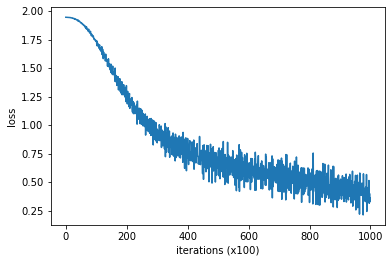

In [51]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000
eval_interval = 200

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size=1)
target = convert_one_hot(target, vocab_size)
contexts =  convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size, eval_interval=100)
trainer.plot()

In [55]:
word_vecs = model.word_vecs

for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.5453827 -1.1059792 -1.1511161 -0.5819494  1.1674844]
say [-0.5813489   1.1815686   1.1846436   0.03516261 -1.1850824 ]
goodbye [-0.35639533 -0.79218745 -0.7693759   1.479449    0.6887518 ]
and [-1.6112465   0.9196267   0.93049693 -1.5126876  -0.9213449 ]
i [-0.3651697  -0.77786314 -0.76457274  1.4934592   0.68853694]
hello [-1.5454439 -1.1294364 -1.1397979 -0.584809   1.1681837]
. [ 1.4954163  1.101779   1.0781047  1.3852026 -1.0819888]


$A$という事象が起こる確率を$P(A)$と書き、「$A$と$B$が同時に起こる確率」は**同時確率**と呼び$P(A,B)$とかく。  
また、「$B$という情報が与えられたときに、$A$が起こる確率」を**事後確率**と呼び$P(A|B)$と表す。  
$w_1,w_2,\cdots,w_T$という単語の列で表されるコーパスを扱うとすると、  
コンテキストとして$w_{t-1}$、$w_{t+1}$が与えられたときに、ターゲットが$w_t$となる確率は、
$$
P(w_t|w_{t-1},w_{t+1})
$$
と書くことができる。  
**負の対数尤度**は、
$$
L=-\log{P(w_t|w_{t-1},w_{t+1})}
$$
と書くことができて、コーパス全体に拡張すると、
$$
L=-\frac{1}{T}\sum_{t=1}^T\log{P(w_t|w_{t-1},w_{t+1})}
$$
と書ける。

#### skip-gramモデル
CBOWで扱うコンテキストとターゲットを逆転させたモデルで、  
中央の単語(ターゲット)から、周囲の複数ある単語(コンテキスト)を推測する。  
確率でskip-gramモデルを表すと、「$w_t$が与えられたときに、$w_{t-1}$と$w_{t+1}$が同時に起こる確率」となるので
$$
P(w_{t-1},w_{t+1}|w_t)
$$
と書ける。  
コンテキストの単語の間に関連性がないと仮定すると、
$$
P(w_{t-1},w_{t+1}|w_t)=P(w_{t-1}|w_t)P(w_{t+1}|w_t)
$$
損失関数は交差エントロピー誤差に適用することで、
$$
L=-\log{P(w_{t-1},w_{t+1}|w_t)}=-(\log{P(w_{t-1}|w_t)}+\log{P(w_{t+1}|w_t)})
$$
コーパス全体に拡張すると、
$$
L=-\frac{1}{T}\sum_{t=1}^T(\log{P(w_{t-1}|w_t)}+\log{P(w_{t+1}|w_t)})
$$


In [56]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 101 |  iter 1 / 2 | time 0[s] | loss 3.50
| epoch 201 |  iter 1 / 2 | time 0[s] | loss 2.72
| epoch 301 |  iter 1 / 2 | time 0[s] | loss 2.23
| epoch 401 |  iter 1 / 2 | time 0[s] | loss 2.02
| epoch 501 |  iter 1 / 2 | time 0[s] | loss 1.77
| epoch 601 |  iter 1 / 2 | time 0[s] | loss 2.18
| epoch 701 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 801 |  iter 1 / 2 | time 0[s] | loss 2.13
| epoch 901 |  iter 1 / 2 | time 0[s] | loss 1.67


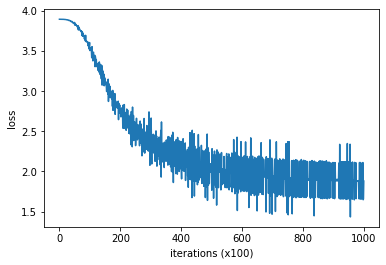

In [65]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000
eval_interval = 200

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size=1)
target = convert_one_hot(target, vocab_size)
contexts =  convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size, eval_interval=100)
trainer.plot()

In [66]:
word_vecs = model.word_vecs

for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.01092086  0.01764772 -0.00387958 -0.01076507  0.00539771]
say [ 0.6594897  -1.1946642   0.8891292  -0.8312822   0.40401164]
goodbye [-0.87017876  0.7940814  -0.78657174  0.8395835  -1.3091013 ]
and [ 1.1279892  0.0731364  0.9573826 -1.0665976 -1.3647411]
i [-0.88903165  0.797176   -0.7941236   0.8051016  -1.307444  ]
hello [-0.5828587   1.0299876  -0.94866025  0.82907915  1.2038207 ]
. [0.00564241 0.01827684 0.00389403 0.01849347 0.00568972]


#### Embeddingレイヤ
入力の単語のone-hotベクトルと重み行列の積は、行列から該当する行を抜き出すことに相当することであった。  
MatMulレイヤでなく、単語IDに該当する行を抜き出すためのレイヤとして**Embeddingレイヤ**を作る。

In [67]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.grads = None
    
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0 # dWの要素を0で上書き
        
        for i, word_id in enumerate(self.idx):
            # 該当する行にのみ勾配を伝える
            dW[word_id] += dout[i] # IDが重複した場合は加算していく
        
        return None

#### Negative sampling
今までは各単語の確率を求める「多値分類」を行ってきたが、「目的の単語であるかどうか」の「2値分類」を考えることにする。  
中間層から出力層に向かうとき、重み行列の目的となる単語に対応する列ベクトルのみを掛け合わせる処理を行う。  
2値分類の場合、出力層にはSoftmax関数、損失関数には交差エントロピー誤差を用いる。

In [ ]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
    
    def forward(self, h, idx):
        # 該当する行を抜き出す
        target_W = self.embed.forward(idx)
        # 中間層からの出力と掛け合わせ、各要素を足し合わせる
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

いままでの方法であると正例のみ学習させることになるため、負例もいくつかサンプリングして損失を求める。  
この手法を**Negative Sampling**と呼ぶ。  
計算としては、各単語の損失を足し合わせて最終的な損失とするだけである。  
また、負例のサンプリングについては単語の出現回数をもとに頻度が高いものが選ばれやすくする。  
また、Nrgative samplingでは、確率分布に対して以下のように0.75乗する工夫がされている(低確率の単語が少しだけサンプリングされやすくなる)。
$$
P'(w_i)=\frac{P(w_i)^{0.75}}{\sum_{j}^nP(w_j)^{0.75}}
$$

In [73]:
import collections
GPU = False

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [74]:
# 負例のサンプリング
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[4 2]
 [0 4]
 [1 3]]


In [ ]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        # 正例1つ、負例のレイヤをsample_size個だけ生成
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, h, target):
        # h: 中間層のニューロン
        batch_size = target.shape[0]
        # 負例のサンプリング
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 負例のフォワード
        # 正解ラベルは0
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
        
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

#### 改良版word2vecの学習

In [ ]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # すべての重みと勾配を配列にまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

In [75]:
import pickle

window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.loda_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs

if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float32)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

NameError: name 'ptb' is not defined

In [84]:
pkl_file = 'C:/Users/tanak/study/参考書/ゼロからDL2/deep-learning-from-scratch-2-master/ch04/cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625


「king - man + woman = queen」で有名な**アナロジー問題**という類似問題を、分散表現の加算と減算で解くことができる。

In [87]:
def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s is not found' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return
    
def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

In [91]:
analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs, top=5)


[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375


分散表現については、ゼロから学習することはなく、先に大きなコーパス(Wikipediaなど)で学習を行い、  
その学習済みの分散表現を個別タスクで利用する。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

# 前処理
def preprocess(text):
    # 前処理
    text = text.lower() # すべての文字を小文字に変換
    text = text.replace('.', ' .') # 「.」も1単語として扱うためスペースを入れる。
    words = text.split(' ')
    
    # 単語辞書、ID辞書の作成
    word_to_id = {} # 単語: ID
    id_to_word = {} # ID: 単語

    for word in words: # 単語のリスト
        if word not in word_to_id: # word_to_idに存在しない場合
            new_id = len(word_to_id) # 新しいIDの発行
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    # コーパスの作成(単語リストをIDリストに変換)
    corpus = [word_to_id[w] for w in words]
    
    return corpus, word_to_id, id_to_word

# 関数
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

def cos_similarity(x, y, eps=1e-8):
    '''コサイン類似度の算出

    :param x: ベクトル
    :param y: ベクトル
    :param eps: ”0割り”防止のための微小値
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''類似単語の検索

    :param query: クエリ（テキスト）
    :param word_to_id: 単語から単語IDへのディクショナリ
    :param id_to_word: 単語IDから単語へのディクショナリ
    :param word_matrix: 単語ベクトルをまとめた行列。各行に対応する単語のベクトルが格納されていることを想定する
    :param top: 上位何位まで表示するか
    '''
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return
            
# optimizer
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

# レイヤ
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

# trainer
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=200):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and ((iters % eval_interval) == 0):
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    if ((self.current_epoch % eval_interval) == 0)and((iters % 2) == 0):
                        print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                              % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()